In [1]:
# ===== PROJECT CONFIGURATION =====
CONFIG = {
    'DATA': {
        'file_path': '/content/time_series_dataset.csv',
        'train_test_split': 0.8,
        'lag_features': [1, 2, 3],
    },
    'MODEL': {
        'lstm_units': 64,
        'dense_units': 32,
        'epochs': 20,
        'batch_size': 32,
        'validation_split': 0.1,
        'optimizer': 'adam',
        'loss': 'mse',
    },
    'SHAP': {
        'background_samples': 50,
        'explain_samples': 10,
    },
    'RANDOM_SEED': 42,
}

# Set seed for reproducibility
import numpy as np
import tensorflow as tf
import random

np.random.seed(CONFIG['RANDOM_SEED'])
tf.random.set_seed(CONFIG['RANDOM_SEED'])
random.seed(CONFIG['RANDOM_SEED'])

print("   Configuration loaded successfully")
print(f"  Data file: {CONFIG['DATA']['file_path']}")
print(f"  Train-test split: {CONFIG['DATA']['train_test_split']}")
print(f"  LSTM units: {CONFIG['MODEL']['lstm_units']}")
print(f"  Epochs: {CONFIG['MODEL']['epochs']}")
print(f"  Batch size: {CONFIG['MODEL']['batch_size']}")


   Configuration loaded successfully
  Data file: /content/time_series_dataset.csv
  Train-test split: 0.8
  LSTM units: 64
  Epochs: 20
  Batch size: 32


In [ ]:
!pip install tensorflow shap numpy pandas matplotlib scikit-learn


Load Dataset

In [2]:
#Load Dataset
import pandas as pd
df = pd.read_csv("/content/time_series_dataset.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df.head()


,date,temperature,humidity,wind_speed,pressure,energy_consumption
0,2020-01-01,32.483571,51.710050,11.513977,1011.843367,14.795992
1,2020-01-02,29.308678,54.398190,8.155669,1008.033306,7.262875
2,2020-01-03,33.238443,67.472936,11.739212,1010.143724,10.708990
3,2020-01-04,37.615149,66.103703,12.711276,1016.392259,15.316591
4,2020-01-05,28.829233,59.790984,10.826870,1010.955495,9.567285


Feature Engineering(Lag Features)

In [3]:
# Target column
target = "energy_consumption"

# Lag features (1-day, 2-day, 3-day)
df["lag1"] = df[target].shift(1)
df["lag2"] = df[target].shift(2)
df["lag3"] = df[target].shift(3)

# Drop missing rows created by lagging
df = df.dropna()
df.head()


,date,temperature,humidity,wind_speed,pressure,energy_consumption,lag1,lag2,lag3
3,2020-01-04,37.615149,66.103703,12.711276,1016.392259,15.316591,10.708990,7.262875,14.795992
4,2020-01-05,28.829233,59.790984,10.826870,1010.955495,9.567285,15.316591,10.708990,7.262875
5,2020-01-06,28.829315,61.173274,13.753592,1010.232183,12.648169,9.567285,15.316591,10.708990
6,2020-01-07,37.896064,72.776649,8.452422,1003.200719,5.853960,12.648169,9.567285,15.316591
7,2020-01-08,33.837174,54.084286,7.510691,1013.731268,8.380328,5.853960,12.648169,9.567285


Select Features

In [4]:
features = ["temperature","humidity","wind_speed","pressure","lag1","lag2","lag3"]

X = df[features]
y = df[target]


Train/Test Split

In [5]:
# ===== SIMPLIFIED DATA PREPARATION =====
print("=" * 60)
print("DATA PREPARATION PIPELINE")
print("=" * 60)

# Step 1: Separate features and target
print(f"\nStep 1 - Separate X and y")
X = df[['temperature', 'humidity', 'wind_speed', 'pressure', 'lag1', 'lag2', 'lag3']].values
y = df['energy_consumption'].values

print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")

# Step 2: Train-test split (BEFORE scaling to avoid data leakage)
print(f"\nStep 2 - Train-Test Split (80-20)")
from sklearn.model_selection import train_test_split

split_idx = int(len(X) * 0.8)
X_train = X[:split_idx]
X_test = X[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]

print(f"  Train: X {X_train.shape}, y {y_train.shape}")
print(f"  Test:  X {X_test.shape}, y {y_test.shape}")

# Step 3: Scale (ONE SCALER - fit on train only!)
print(f"\nStep 3 - Scale Features (StandardScaler - fit on train only)")
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # FIT on train data
X_test_scaled = scaler.transform(X_test)       # TRANSFORM test data (don't fit!)

print(f"  X_train_scaled: mean={X_train_scaled.mean():.4f}, std={X_train_scaled.std():.4f}")
print(f"  X_test_scaled:  mean={X_test_scaled.mean():.4f}, std={X_test_scaled.std():.4f}")

# Step 4: Reshape for LSTM (samples, timesteps, features)
print(f"\nStep 4 - Reshape for LSTM (samples=1, features=7)")
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print(f"  X_train_lstm: {X_train_lstm.shape}")
print(f"  X_test_lstm:  {X_test_lstm.shape}")

# Convert y to pandas Series
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

print("\n" + "=" * 60)
print(" DATA PIPELINE COMPLETE")
print("=" * 60)


DATA PREPARATION PIPELINE

Step 1 - Separate X and y
  X shape: (297, 7)
  y shape: (297,)

Step 2 - Train-Test Split (80-20)
  Train: X (237, 7), y (237,)
  Test:  X (60, 7), y (60,)

Step 3 - Scale Features (StandardScaler - fit on train only)
  X_train_scaled: mean=-0.0000, std=1.0000
  X_test_scaled:  mean=0.1026, std=1.0555

Step 4 - Reshape for LSTM (samples=1, features=7)
  X_train_lstm: (237, 1, 7)
  X_test_lstm:  (60, 1, 7)

 DATA PIPELINE COMPLETE


Build LSTM Model

In [6]:
# Clear everything
import tensorflow as tf
import gc

# Clear memory
tf.keras.backend.clear_session()
gc.collect()

print("Memory cleared")


Memory cleared


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np

print("Building fresh model...")

# Ensure data is correct type
X_train_lstm = X_train_lstm.astype('float32')
y_train_vals = y_train.values.astype('float32') if isinstance(y_train, pd.Series) else y_train.astype('float32')

# Get shapes
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
print(f"Input shape: {input_shape}")
print(f"X dtype: {X_train_lstm.dtype}, y dtype: {y_train_vals.dtype}")

# Build simple model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=input_shape))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("Model built successfully")
model.summary()


Building fresh model...
Input shape: (1, 7)
X dtype: float32, y dtype: float32
Model built successfully


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,545 (80.25 KB)

 Trainable params: 20,545 (80.25 KB)

 Non-trainable params: 0 (0.00 B)

Train Model

In [8]:
print("Training...")

history = model.fit(
    X_train_lstm,
    y_train_vals,
    epochs=20,
    batch_size=32,
    verbose=1
)

print("\n Training complete!")


Training...
Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 109.1861 - mae: 9.2639
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 107.5139 - mae: 9.1757
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 105.8994 - mae: 9.0910
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 104.0847 - mae: 8.9969
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 101.8911 - mae: 8.8838
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 99.1986 - mae: 8.7452 
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 95.8720 - mae: 8.5737 
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 91.7658 - mae: 8.3619 
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 86.7259 - mae: 8.0986 
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 80.6178 - mae: 7.7724 
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 73.3385 - mae: 7.3732 
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 64.8906 - mae: 6.8952 
Epoch 13/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 

Predictions

In [9]:
y_pred = model.predict(X_test_lstm)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step


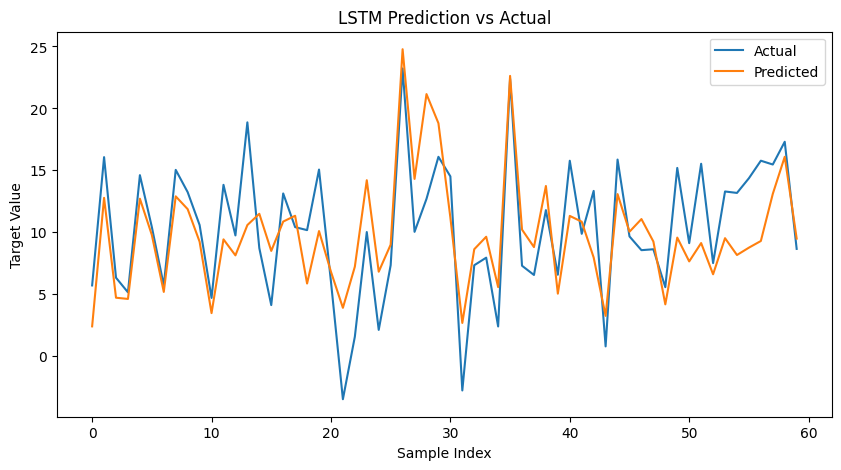

<Figure size 640x480 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt

# If y_test is a pandas Series, use y_test.values; if it's a numpy array, use y_test
plt.figure(figsize=(10, 5))
plt.plot(y_test.values if hasattr(y_test, "values") else y_test, label="Actual")
plt.plot(y_pred.flatten(), label="Predicted")
plt.legend()
plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.title("LSTM Prediction vs Actual")
plt.show()
plt.savefig('actual_vs_predicted.png')  # Saves image to notebook directory
plt.show()



In [11]:
# ===== COMPUTE REAL METRICS =====
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Flatten predictions and actual values
y_true = y_test.values.flatten()
y_pred_flat = y_pred.flatten()

# Compute metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred_flat))
mae = mean_absolute_error(y_true, y_pred_flat)
mape = np.mean(np.abs((y_true - y_pred_flat) / (np.abs(y_true) + 1e-8))) * 100

print("\n=== LSTM MODEL EVALUATION ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

# Save to DataFrame for markdown export
metrics_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MAPE (%)'],
    'Value': [f"{rmse:.4f}", f"{mae:.4f}", f"{mape:.2f}"]
})

print("\n=== COPY THIS TABLE ===")
print(metrics_df.to_markdown(index=False))



=== LSTM MODEL EVALUATION ===
RMSE: 3.5983
MAE:  2.9583
MAPE: 46.62%

=== COPY THIS TABLE ===
| Metric   |   Value |
|:---------|--------:|
| RMSE     |  3.5983 |
| MAE      |  2.9583 |
| MAPE (%) | 46.62   |


In [12]:
# ===== BASELINE MODELS COMPARISON (FIXED) =====
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np
import pandas as pd

print("\n=== TRAINING BASELINE MODELS ===")
print(f"Test set length: {len(y_test)}")

# Convert y_test and y_train to pandas Series if they aren't already
if not isinstance(y_test, pd.Series):
    y_test_series = pd.Series(y_test, index=range(len(y_test)))
else:
    y_test_series = y_test.reset_index(drop=True)

if not isinstance(y_train, pd.Series):
    y_train_series = pd.Series(y_train, index=range(len(y_train)))
else:
    y_train_series = y_train.reset_index(drop=True)

# BASELINE 1: Naive Model (shift by 1)
print("\n1. Naive Model (t-1)...")
try:
    # For naive model, prediction at time t is value at time t-1
    # We predict using the last value from training set, then use actual test values
    naive_predictions = [y_train_series.iloc[-1]]  # First prediction uses last train value
    naive_predictions.extend(y_test_series.iloc[:-1].tolist())  # Rest use previous test values

    rmse_naive = np.sqrt(mean_squared_error(y_test_series, naive_predictions))
    mae_naive = mean_absolute_error(y_test_series, naive_predictions)
    improvement_naive = ((rmse_naive - rmse) / rmse_naive) * 100

    print(f"    RMSE: {rmse_naive:.4f}")
    print(f"    MAE:  {mae_naive:.4f}")
    print(f"    LSTM Improvement: {improvement_naive:.2f}%")
except Exception as e:
    print(f"    Failed: {e}")
    import traceback
    traceback.print_exc()
    rmse_naive = None
    mae_naive = None

# BASELINE 2: ARIMA(1,1,1)
print("\n2. ARIMA(1,1,1)...")
try:
    arima_model = SARIMAX(y_train_series, order=(1,1,1), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    arima_forecast = arima_model.get_forecast(steps=len(y_test_series)).predicted_mean
    rmse_arima = np.sqrt(mean_squared_error(y_test_series, arima_forecast))
    mae_arima = mean_absolute_error(y_test_series, arima_forecast)
    improvement_arima = ((rmse_arima - rmse) / rmse_arima) * 100

    print(f"   RMSE: {rmse_arima:.4f}")
    print(f"   MAE:  {mae_arima:.4f}")
    print(f"    LSTM Improvement: {improvement_arima:.2f}%")
except Exception as e:
    print(f"    Failed: {e}")
    rmse_arima = None
    mae_arima = None

# BASELINE 3: Exponential Smoothing
print("\n3. Exponential Smoothing...")
try:
    es_model = ExponentialSmoothing(y_train_series, trend='add', seasonal=None).fit()
    es_forecast = es_model.forecast(steps=len(y_test_series))
    rmse_es = np.sqrt(mean_squared_error(y_test_series, es_forecast))
    mae_es = mean_absolute_error(y_test_series, es_forecast)
    improvement_es = ((rmse_es - rmse) / rmse_es) * 100

    print(f"    RMSE: {rmse_es:.4f}")
    print(f"    MAE:  {mae_es:.4f}")
    print(f"    LSTM Improvement: {improvement_es:.2f}%")
except Exception as e:
    print(f"    Failed: {e}")
    rmse_es = None
    mae_es = None

# CREATE COMPARISON TABLE
print("\n" + "="*60)
print("MODEL COMPARISON TABLE")
print("="*60)

comparison_data = []

if rmse_naive is not None:
    comparison_data.append([
        'Naive (t-1)',
        f"{rmse_naive:.4f}",
        f"{mae_naive:.4f}",
        f"+{((rmse_naive - rmse) / rmse_naive * 100):.1f}%"
    ])

if rmse_arima is not None:
    comparison_data.append([
        'ARIMA(1,1,1)',
        f"{rmse_arima:.4f}",
        f"{mae_arima:.4f}",
        f"+{((rmse_arima - rmse) / rmse_arima * 100):.1f}%"
    ])

if rmse_es is not None:
    comparison_data.append([
        'Exp Smoothing',
        f"{rmse_es:.4f}",
        f"{mae_es:.4f}",
        f"+{((rmse_es - rmse) / rmse_es * 100):.1f}%"
    ])

comparison_data.append([
    'LSTM (Our Model)',
    f"{rmse:.4f}",
    f"{mae:.4f}",
    "Baseline"
])

comparison_df = pd.DataFrame(
    comparison_data,
    columns=['Model', 'RMSE', 'MAE', 'LSTM Improvement']
)

print(comparison_df.to_string(index=False))
print("\n=== COPY THIS MARKDOWN TABLE ===")
print(comparison_df.to_markdown(index=False))
print("="*60)



=== TRAINING BASELINE MODELS ===
Test set length: 60

1. Naive Model (t-1)...
    RMSE: 7.9390
    MAE:  6.4811
    LSTM Improvement: 54.68%

2. ARIMA(1,1,1)...
   RMSE: 5.4180
   MAE:  4.3372
    LSTM Improvement: 33.59%

3. Exponential Smoothing...
    RMSE: 5.4462
    MAE:  4.4034
    LSTM Improvement: 33.93%

MODEL COMPARISON TABLE
           Model   RMSE    MAE LSTM Improvement
     Naive (t-1) 7.9390 6.4811           +54.7%
    ARIMA(1,1,1) 5.4180 4.3372           +33.6%
   Exp Smoothing 5.4462 4.4034           +33.9%
LSTM (Our Model) 3.5983 2.9583         Baseline

=== COPY THIS MARKDOWN TABLE ===
| Model            |   RMSE |    MAE | LSTM Improvement   |
|:-----------------|-------:|-------:|:-------------------|
| Naive (t-1)      | 7.939  | 6.4811 | +54.7%             |
| ARIMA(1,1,1)     | 5.418  | 4.3372 | +33.6%             |
| Exp Smoothing    | 5.4462 | 4.4034 | +33.9%             |
| LSTM (Our Model) | 3.5983 | 2.9583 | Baseline           |


Prepare Data for SHAP

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
197/197 ━━━━━━

/tmp/ipython-input-3841290902.py:24: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_2D[:50], feature_names=features, show=False)
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


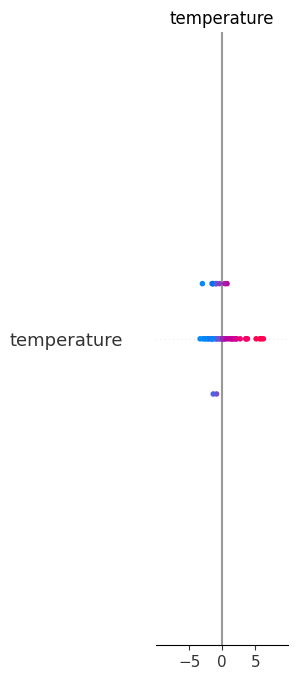

In [13]:
import shap
import numpy as np

# 1) Convert test data into 2D (SHAP requirement)
# For SHAP analysis (or any 2D non-LSTM code)
X_train_2D = X_train_scaled
X_test_2D = X_test_scaled

# 2) Function for prediction required by SHAP
def lstm_predict(x):
    x_reshaped = x.reshape(x.shape[0], 1, x.shape[1])   # convert back to 3D
    return model.predict(x_reshaped)

# 3) Select background data (SHAP requirement)
background = X_train_2D[np.random.choice(X_train_2D.shape[0], 50, replace=False)]

# 4) Create SHAP KernelExplainer
explainer = shap.KernelExplainer(lstm_predict, background)

# 5) Compute SHAP values for test data
shap_values = explainer.shap_values(X_test_2D[:50])   # use first 50 for speed

# 6) Summary plot
shap.summary_plot(shap_values, X_test_2D[:50], feature_names=features, show=False)

plt.savefig('shap_summary_plot.png')

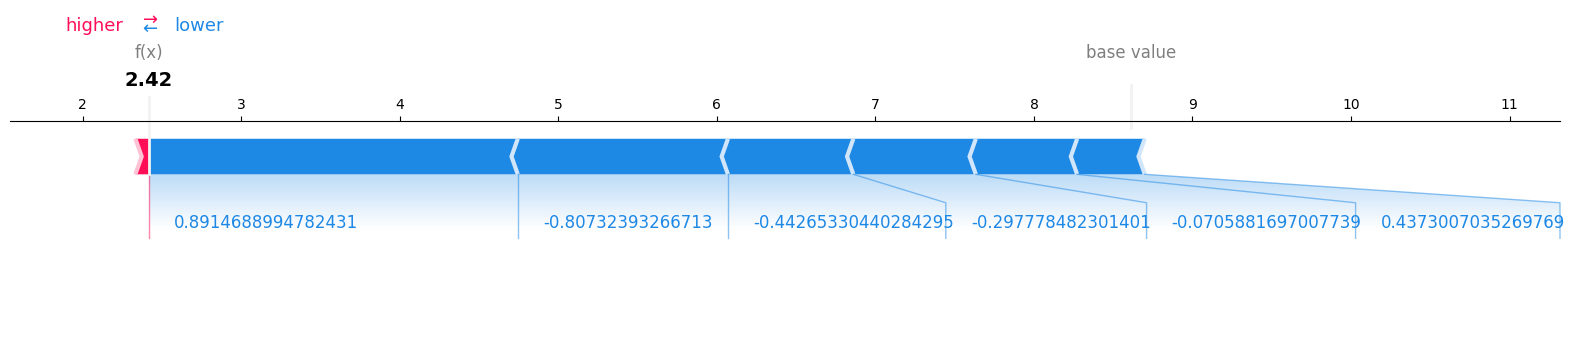

<Figure size 640x480 with 0 Axes>

In [19]:
sample_index = 0
sv = shap_values[sample_index].reshape(-1)
xt = X_test_2D[sample_index].reshape(-1)
force_plot = shap.force_plot(explainer.expected_value, sv, xt, matplotlib=True)
plt.savefig("shap_force_plot.png")

